# Imports

In [1]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as pcm
import random
import cv2



# Data Preprocessing

## Relocate all images into one folder

In [4]:
import glob

# create the dataframe(dataset)
# get the nii files
base_dir = "./ADNI/" 

# an empty array to collect all subjects
images_dict = {}

# read csv file
data = pd.read_csv('./ADNI_400_12_Subjects_8_09_2020.csv')
# add new columns with default values in dataframe
data['original_path'] = ""
data['new_path'] = ""


# create new folder in directoryto save allthe files in to the directory
new_dir = os.path.join(base_dir, 'ADNI_All_Images')
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
    
# get all the unique subject ids in order to search for the nii files in each subject directory
unique_subject_ids = data.Subject.unique()
dictionary_indx = 0

for subj_id in unique_subject_ids:
    # traverse root directory, and list directories as dirs and files as files
    for root, dirs, files in os.walk('./ADNI/'+subj_id+'/'):
        #path = root.split(os.sep)
        for file_path in files:
            image_path = root + "/" + file_path

            # try to open the file if it is a nii file
            if image_path.endswith('.nii'):
                image_data = nib.load(image_path)
                image_affine = image_data.affine
                image_header = image_data.header

                # add the images to the new directory
                #new_image_name = 'image_'+str(index)+'.nii.gz'
                new_path = os.path.join(new_dir, file_path)
                nib.save(image_data,new_path)
                # insert the image data into the images list using their index in the dataframe
                # save the affine of the image into the dictionary for future reference
                dic = {'image':image_data, 'image_path': new_path, 'image_affine': image_affine, 'image_header': image_header}
                images_dict[dictionary_indx] = dic
                dictionary_indx += 1
                
#save a copy of the new dataframe version of the data into the csv file
data.to_csv ('./ADNI1_Baseline_3T_6_17_2020_10samples_newdata.csv', index = False, header=True)


print("len images", len(images_dict))
    

len images 12


## BET (Brain Extraction Tool)

In [5]:
from nipype.interfaces import fsl
from nilearn.plotting import plot_anat



# create new directory for saving the masks
new_dir_mask = os.path.join(base_dir, 'BET_Images')
if not os.path.exists(new_dir_mask):
    os.makedirs(new_dir_mask)

    
# create masks forimages in the dictionary
for index, value in images_dict.items():
        if type(value) is dict:
            
            # get the image from the dictionary
            image = value['image']
            image_path = value['image_path']
            affine = value['image_affine']
            header = value['image_header']
            # Load a nifti as 3d numpy image [H, W, D]
            image_data = image.get_fdata()
            
            # FSL --- BET
            # masked image directory info
            new_mask_name = "{0}_{2}.{1}".format(*image_path.replace("./ADNI/ADNI_All_Images/", "").rsplit('.', 1) + ['BET'])
            print(new_mask_name)
            new_masked_path = os.path.join(new_dir_mask, new_mask_name)
            
            # BET
            btr = fsl.BET()
            btr.inputs.in_file = image_path
            btr.inputs.out_file = new_masked_path
            btr.inputs.frac = 0.5
            res = btr.run()
            
            # save the extracted images as a new object in dictionary
            images_dict[index]['mask'] = nib.load(new_masked_path + '.gz')

            # add the path to the masks in the dictionary for future reference
            images_dict[index]['mask_path'] = new_masked_path + ".gz"
                
        else:
            print('is not a dictionary')
           
            

ADNI_941_S_1203_MR_MPRAGE_Repeat__br_raw_20090225164033507_141_S63605_I137049_BET.nii
ADNI_941_S_1194_MR_MPRAGE_Repeat__br_raw_20070120170232109_90_S25324_I37063_BET.nii
ADNI_141_S_1152_MR_MPRAGE_Repeat__br_raw_20061227094554309_138_S24488_I34284_BET.nii
ADNI_141_S_0767_MR_MPRAGE_Repeat__br_raw_20080212141951316_37_S27492_I42710_BET.nii
ADNI_133_S_1170_MR_Sag_MPRAGE_br_raw_20090317152443078_1_S64730_I139305_BET.nii
ADNI_133_S_1170_MR_Sag_MPRAGE_br_raw_20090317152549156_1_S64729_I139304_BET.nii
ADNI_133_S_0525_MR_Sag_MPRAGE_br_raw_20090629131454625_1_S69256_I146835_BET.nii
ADNI_133_S_0493_MR_Sag_MPRAGE_br_raw_20090518144303437_1_S67362_I144034_BET.nii
ADNI_133_S_0433_MR_Sag_MPRAGE_br_raw_20090526145439140_1_S67659_I144502_BET.nii
ADNI_133_S_0433_MR_Sag_MPRAGE_br_raw_20090526145535140_1_S67660_I144503_BET.nii
ADNI_130_S_1337_MR_MPRAGE_SENSE_br_raw_20080310151436028_4_S46831_I96399_BET.nii
ADNI_130_S_1337_MR_MPRAGE_SENSE_repeat__br_raw_20070323092644021_2_S28789_I46444_BET.nii


#### visualize the original MRI Image with Scalp (BET)

./ADNI/ADNI_All_Images/ADNI_133_S_0493_MR_Sag_MPRAGE_br_raw_20090518144303437_1_S67362_I144034.nii


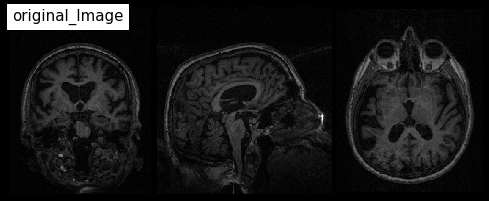

In [6]:
mask = images_dict[7]['mask'].get_fdata()
plot_anat(images_dict[7]['image_path'], title='original_Image', display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
print(images_dict[7]['image_path'])

#### visualize the extracted brains (BET)

./ADNI/BET_Images/ADNI_133_S_0493_MR_Sag_MPRAGE_br_raw_20090518144303437_1_S67362_I144034_BET.nii.gz


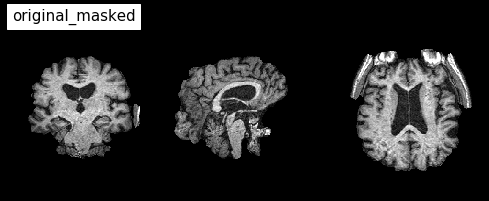

In [4]:
mask = images_dict[7]['mask'].get_fdata()
plot_anat(images_dict[7]['mask_path'], title='original_masked', display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
print(images_dict[7]['mask_path'])

## Registration : FLIRT

In [5]:
import nipype.interfaces.fsl as fsl
import os
import subprocess

# test the same directory for registration
mask_copy = os.path.join(base_dir, 'BET_Images')
if not os.path.exists(mask_copy):
    os.makedirs(mask_copy)

command = 'find ' + mask_copy + ' | grep _BET.nii.gz'

output = subprocess.run(command,
                        shell=True,
                        stdout=subprocess.PIPE,
                        universal_newlines=True)

paths = output.stdout.split()


# Apply FLIRT 
for path in paths:
    flt = fsl.FLIRT(bins=256, cost='corratio', searchr_x=[-90, 90], searchr_y=[-90, 90], searchr_z=[-90, 90], dof=12
                    , interp='trilinear')
    ps = path.split('/')
    flt_file = ps[len(ps) - 1:len(ps)]   # to extract the name of the file from the directory
    flt.inputs.in_file = path
    flt.inputs.out_file = mask_copy + '/' + flt_file[0] #+ '_flirt.nii.gz'
    flt.inputs.reference = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'
    res = flt.run()


./ADNI/BET_Images/ADNI_130_S_1337_MR_MPRAGE_SENSE_br_raw_20080310151436028_4_S46831_I96399_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_130_S_1337_MR_MPRAGE_SENSE_repeat__br_raw_20070323092644021_2_S28789_I46444_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_133_S_0433_MR_Sag_MPRAGE_br_raw_20090526145439140_1_S67659_I144502_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_133_S_0433_MR_Sag_MPRAGE_br_raw_20090526145535140_1_S67660_I144503_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_133_S_0493_MR_Sag_MPRAGE_br_raw_20090518144303437_1_S67362_I144034_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_133_S_0525_MR_Sag_MPRAGE_br_raw_20090629131454625_1_S69256_I146835_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_133_S_1170_MR_Sag_MPRAGE_br_raw_20090317152443078_1_S64730_I139305_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_133_S_1170_MR_Sag_MPRAGE_br_raw_20090317152549156_1_S64729_I139304_BET.nii.gz_flirt.nii.gz
./ADNI/BET_Images/ADNI_141_S_0767_MR_MPRAGE_Repeat__br_raw_20080212141951316_3

#### Visualize the results from the flirt

./ADNI/BET_Images/ADNI_133_S_0493_MR_Sag_MPRAGE_br_raw_20090518144303437_1_S67362_I144034_BET.nii.gz


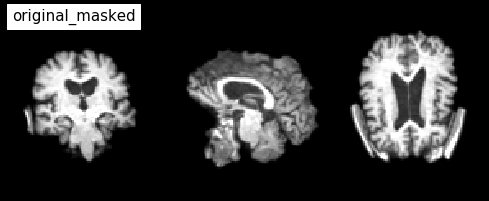

In [6]:
flirt_path = images_dict[7]['mask_path'] #.replace('BET_Images', 'BET_Images_copy')
plot_anat(flirt_path, title='original_masked', display_mode='ortho', dim=-1, draw_cross=False, annotate=False);


## Slicing and Smoothing Images

In [7]:
import matplotlib.image as pltimage


# Slicing function
def get_slice_range(img, area):
    start = 0
    end = 0
    starting = True
    for u in range(0, img.shape[2]):
        slice = img[:, :, u]
        im_sum = np.sum(slice[:, :])
        if im_sum >= area:
            if starting:
                start = u
                starting = False
        elif im_sum < area and not starting:
            end = u - 1
            break
    return [start, end]


        

# slicing the masks and images        
def seg_save_brains(path, mask_img, smoothed_img, sample, color='gray', area=20):
    # mask_img and smoothed_img are 3D at this point
    start, end = get_slice_range(mask_img, area)
    range_zones = end - start
    train = range(start, start + range_zones)
    c_train = train[:]
    # python 3.6 shuffle problem should use list for 2.7 works
    random.shuffle(list(c_train))
    for zone_slice in train:
        path_splited = path.split('/')
        file_to_save = path_splited[len(path_splited) - 1:][0] + '_z_' + str(zone_slice) \
                       + '.png'
        
        if not os.path.exists('ADNI/T1/validation/mask'):
            os.makedirs('ADNI/T1/validation/mask')
        if not os.path.exists('ADNI/T1/validation/images'):
            os.makedirs('ADNI/T1/validation/images')
        if not os.path.exists('ADNI/T1/train/mask'):
            os.makedirs('ADNI/T1/train/mask')
        if not os.path.exists('ADNI/T1/train/images'):
            os.makedirs('ADNI/T1/train/images')
        if not os.path.exists('ADNI/T1/test/mask'):
            os.makedirs('ADNI/T1/test/mask')
        if not os.path.exists('ADNI/T1/test/images'):
            os.makedirs('ADNI/T1/test/images')
        the_mask_slice = mask_img[:, :, zone_slice]
        the_img_slice = smoothed_img[:, :, zone_slice]

        if sample == 'test':
            pltimage.imsave('ADNI/T1/test/images/' + file_to_save, the_img_slice, cmap=color)
            cv2.imwrite('ADNI/T1/test/mask/' + file_to_save, the_mask_slice)
            
            plt.figure(figsize=(10, 10))
            plt.subplot(241)
            plt.axis('off')
            plt.imshow(the_img_slice, cmap='jet')
            plt.title("Original val image") 
            plt.subplot(245)
            plt.axis('off')
            plt.imshow(the_mask_slice, cmap='jet')
            plt.title("mask val image")   

            continue
        elif sample == 'train':
            pltimage.imsave('ADNI/T1/train/images/' + file_to_save, the_img_slice, cmap=color)
            cv2.imwrite('ADNI/T1/train/mask/' + file_to_save, the_mask_slice)
        elif sample == 'val':
            pltimage.imsave('ADNI/T1/validation/images/' + file_to_save, the_img_slice, cmap=color)
            cv2.imwrite('ADNI/T1/validation/mask/' + file_to_save, the_mask_slice)
        else:
            print('')


## Retrieving Atlas Methods

In [8]:
# Retrieving the atlas data

from nilearn import datasets, image


ATLAS_NAME = 'cort-maxprob-thr0-2mm'
data_dir = base_dir


def multiply_regions(region1, filename):
    regions_image1 = region1.get_data()
    region2 = image.load_img(filename)
    regions_image2 = region2.get_data()
    mr = np.multiply(regions_image1, regions_image2)
    return image.new_img_like(region1, mr)


def get_mult_atlas(the_nii_file, the_index, atlas_name):
    dataset = datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir=base_dir)
    atlas_filename = dataset.maps
    atlas_labels = dataset.labels
    print('Atlas ROIs are located at: %s' % atlas_filename)

    region_img = image.load_img(atlas_filename)  # get_labeled_region(index=the_index, atlas_filename=the_atlas_filename)
    return multiply_regions(region_img, the_nii_file), atlas_labels, region_img


def get_seg_atlas(atlas_name):
    dataset = datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir=base_dir)
    atlas_filename = dataset.maps
    atlas_labels = dataset.labels
    return atlas_labels, image.load_img(atlas_filename)  # get_labeled_region(the_index, the_atlas_filename)


#### Put together the slicing and the atlas functions


each image is smoothed and then sliced into 71, 2D .png images and devided into training, validation and test sets


Dataset created in ./ADNI/fsl



Downloaded 25716861 of 25716861 bytes (100.0%,    0.0s remaining) ...done. (18 seconds, 0 min)
Extracting data from ./ADNI/fsl/1f4b7da5a78496f5600009b7964e8346/HarvardOxford.tgz..... done.
/Users/maryam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


labels:  ['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Para

/Users/maryam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


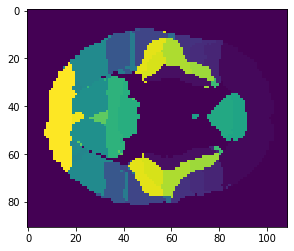

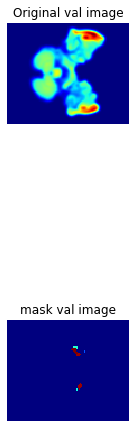

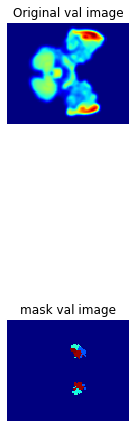

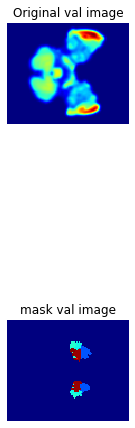

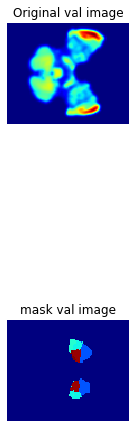

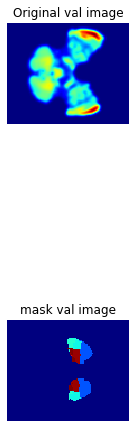

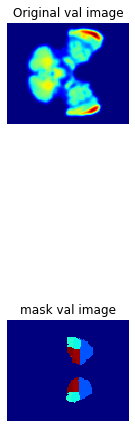

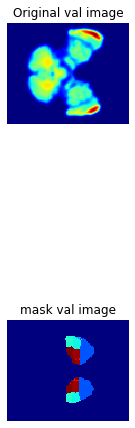

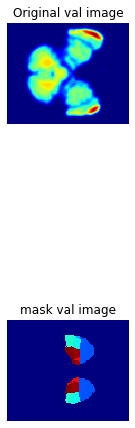

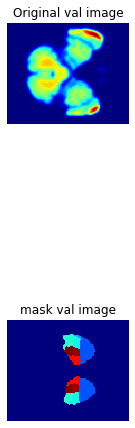

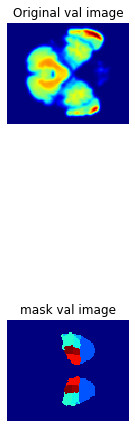

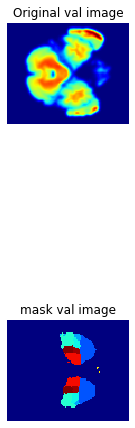

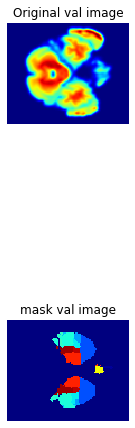

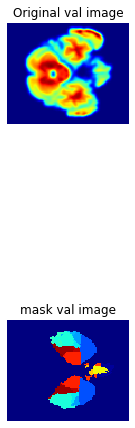

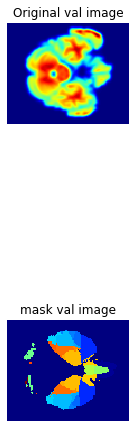

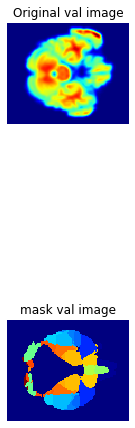

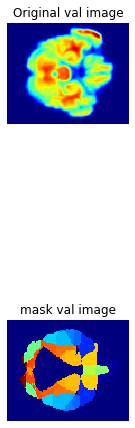

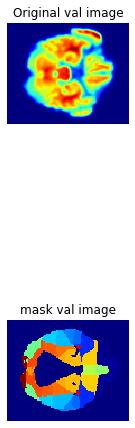

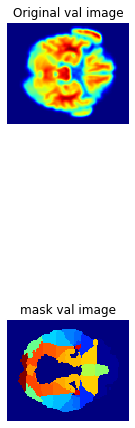

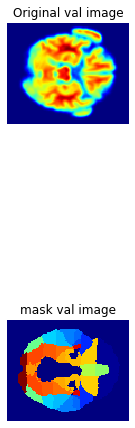

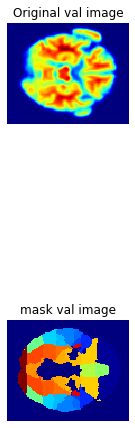

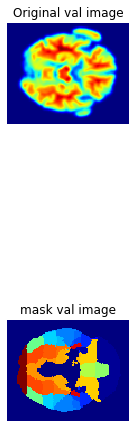

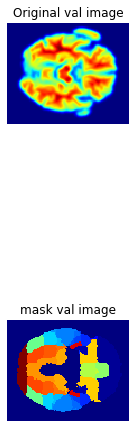

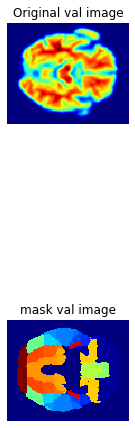

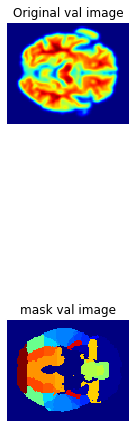

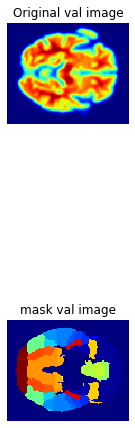

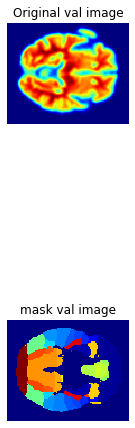

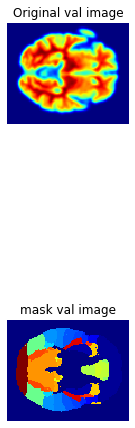

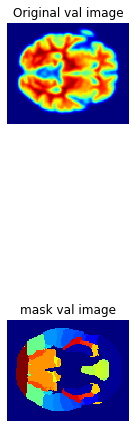

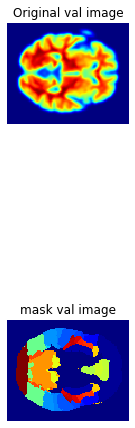

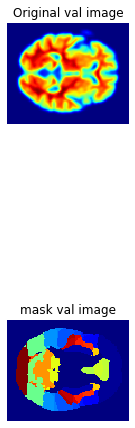

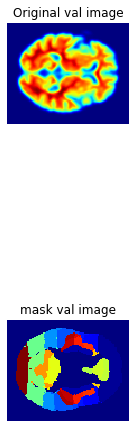

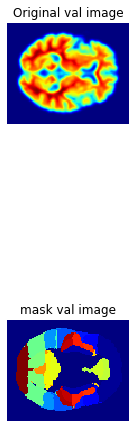

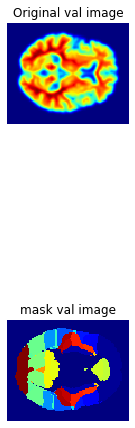

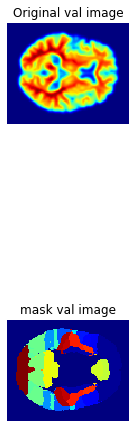

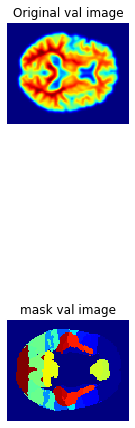

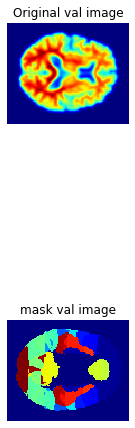

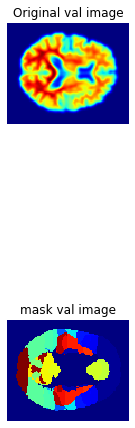

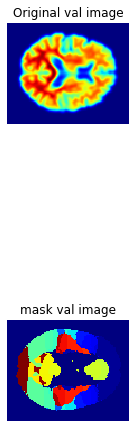

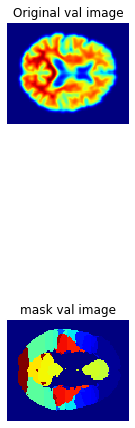

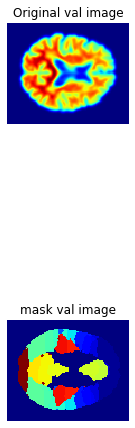

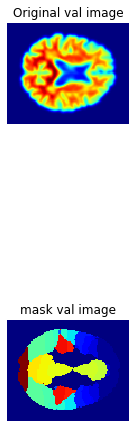

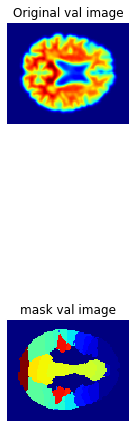

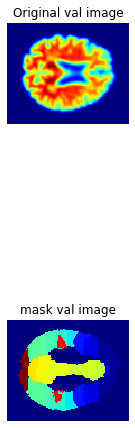

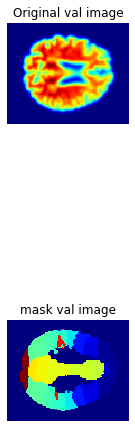

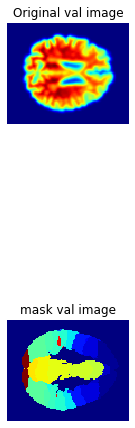

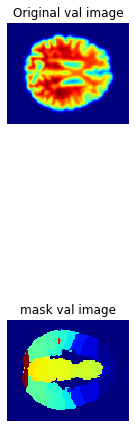

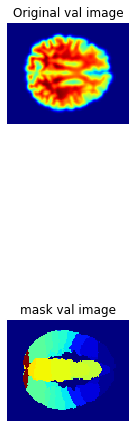

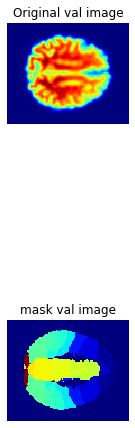

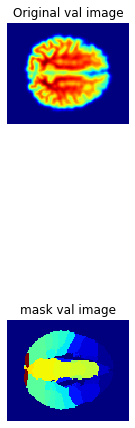

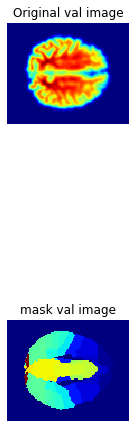

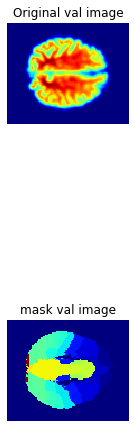

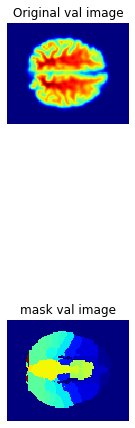

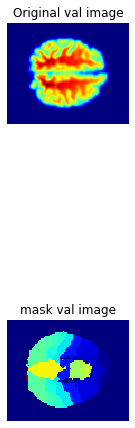

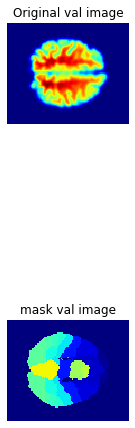

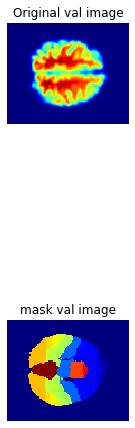

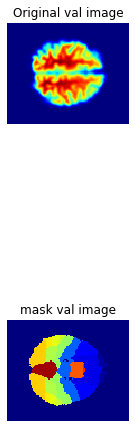

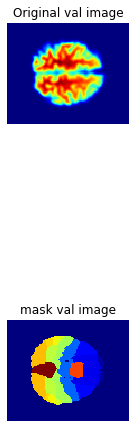

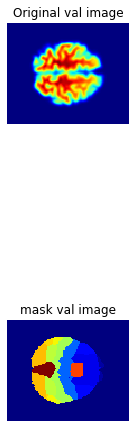

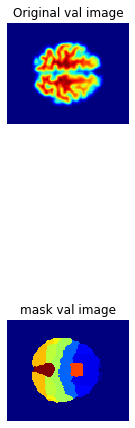

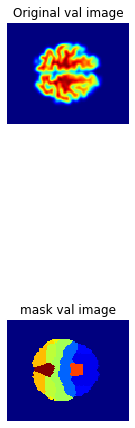

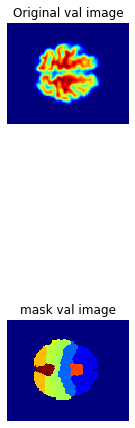

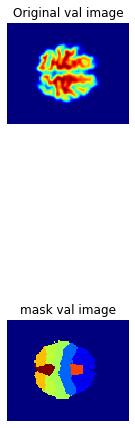

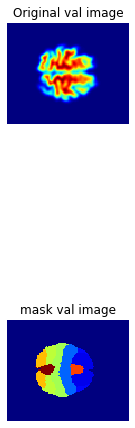

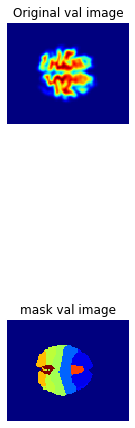

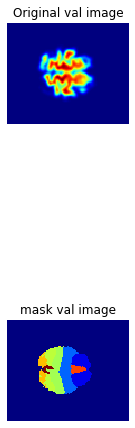

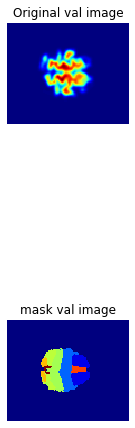

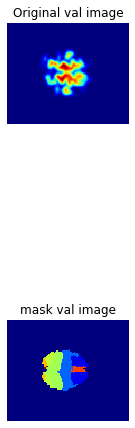

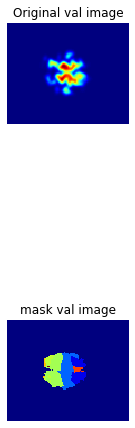

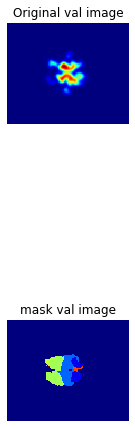

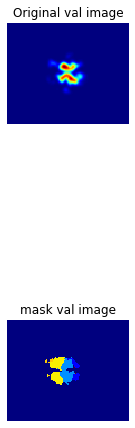

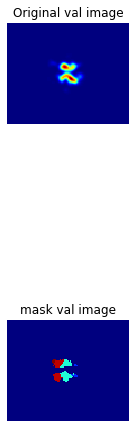

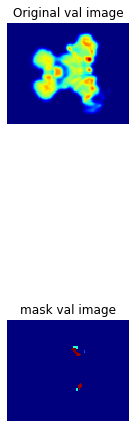

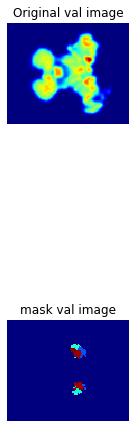

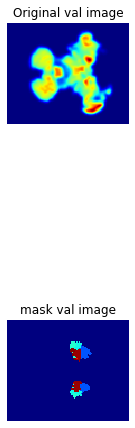

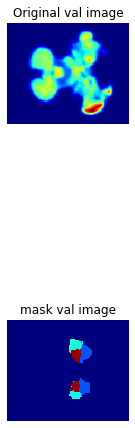

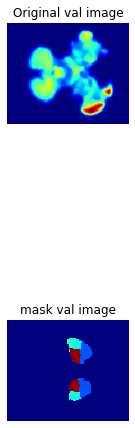

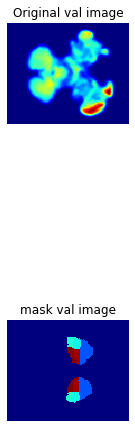

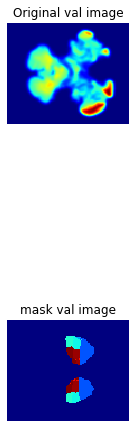

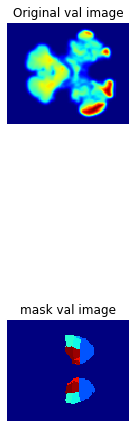

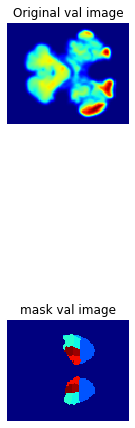

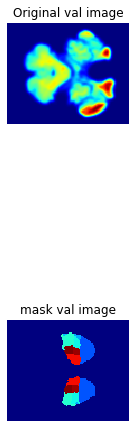

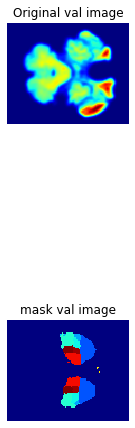

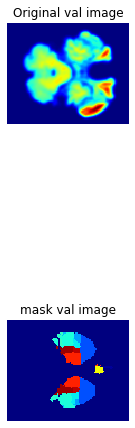

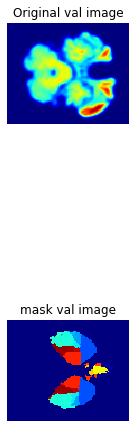

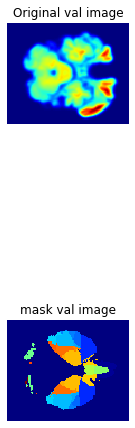

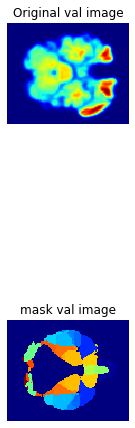

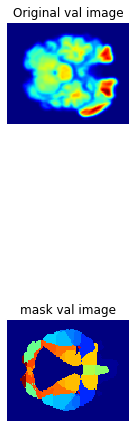

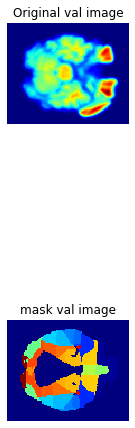

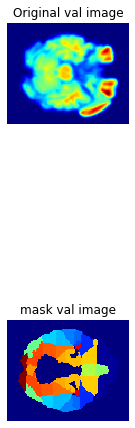

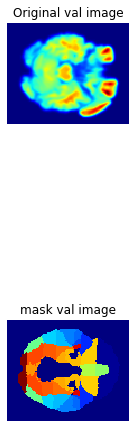

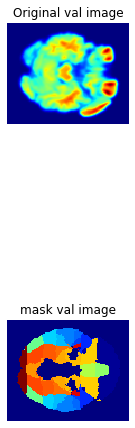

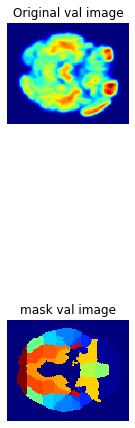

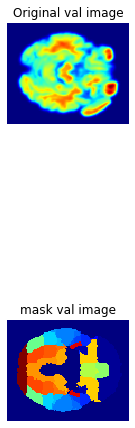

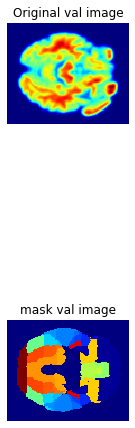

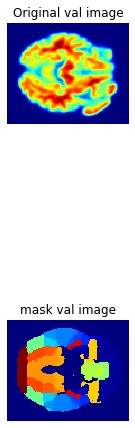

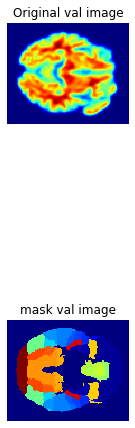

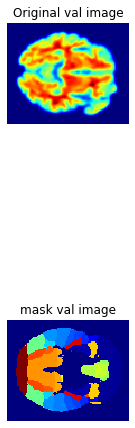

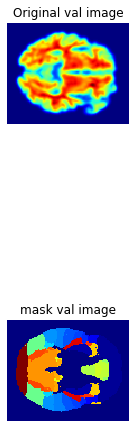

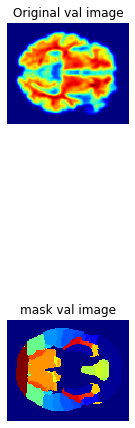

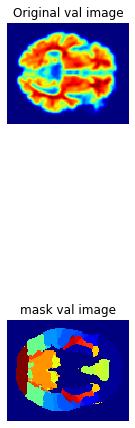

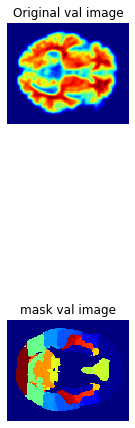

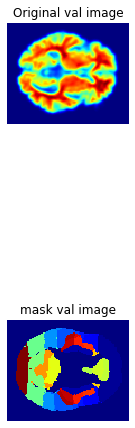

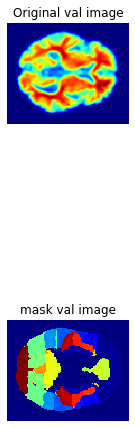

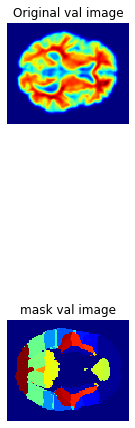

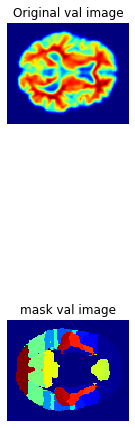

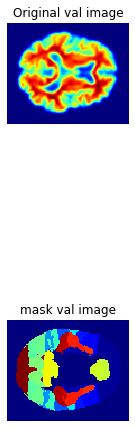

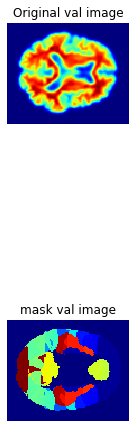

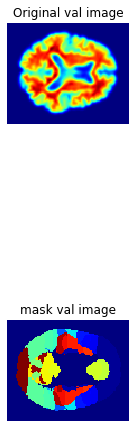

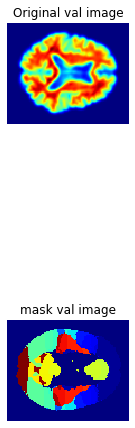

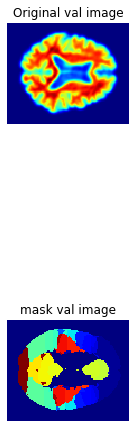

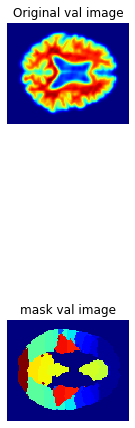

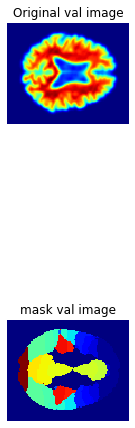

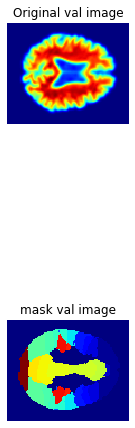

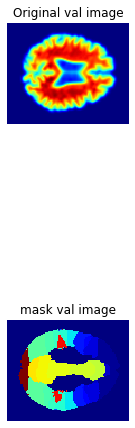

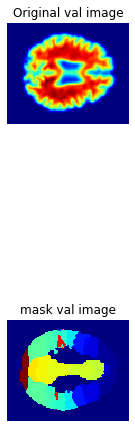

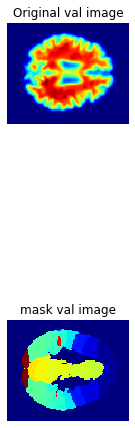

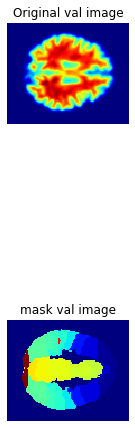

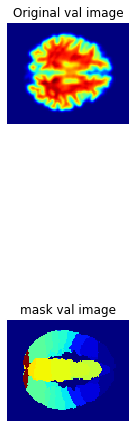

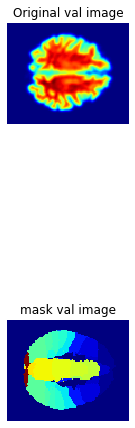

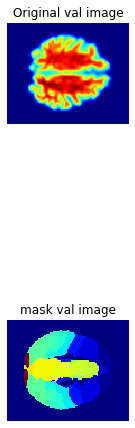

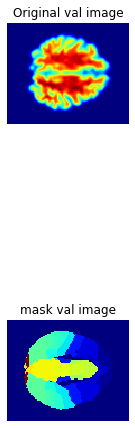

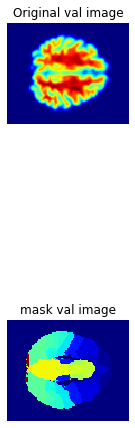

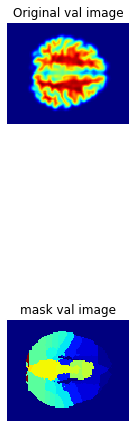

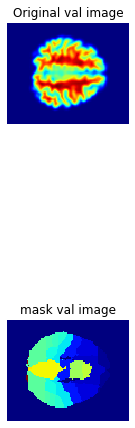

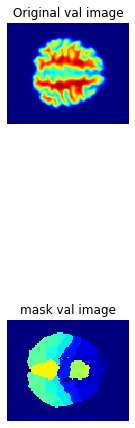

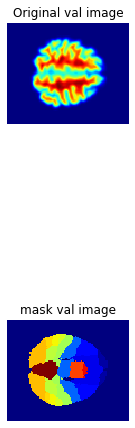

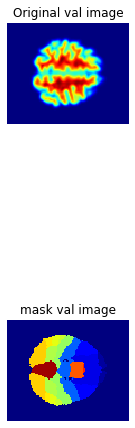

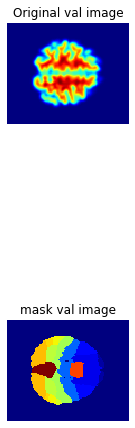

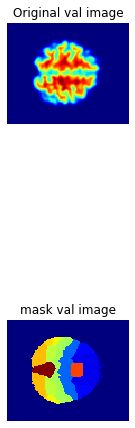

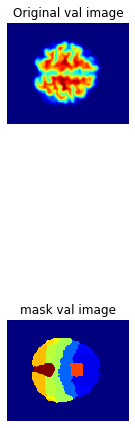

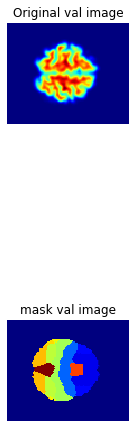

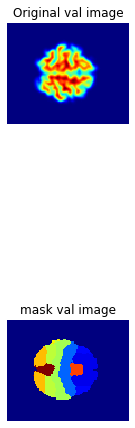

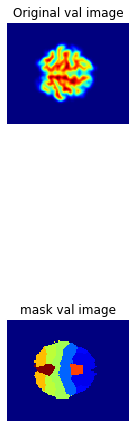

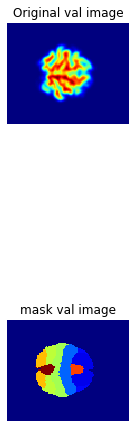

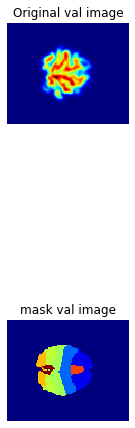

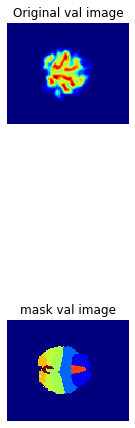

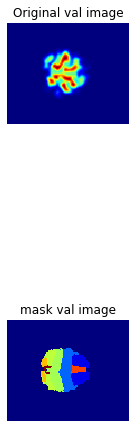

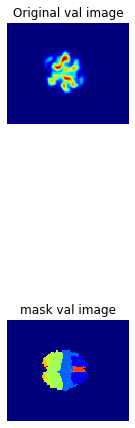

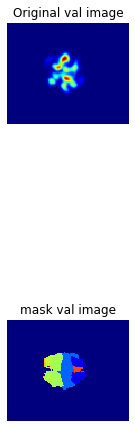

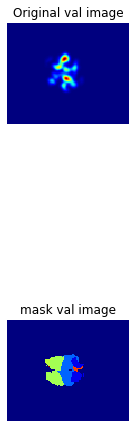

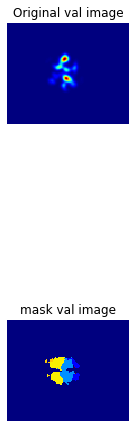

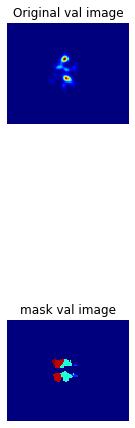

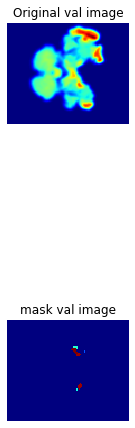

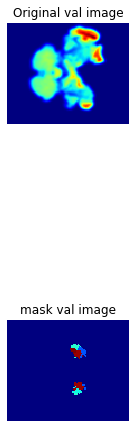

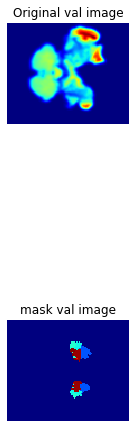

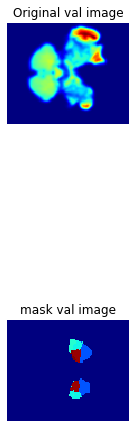

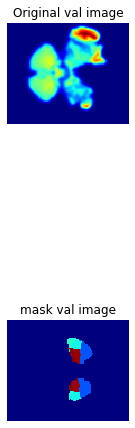

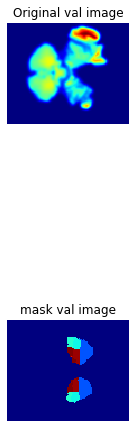

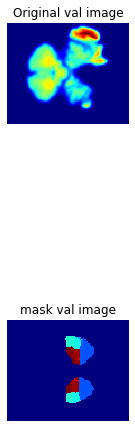

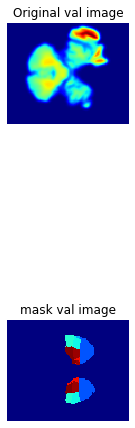

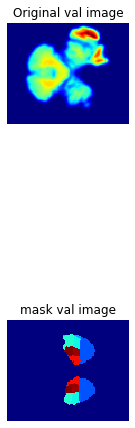

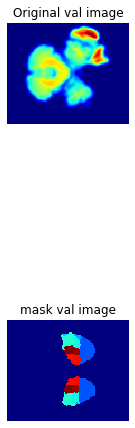

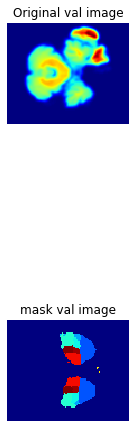

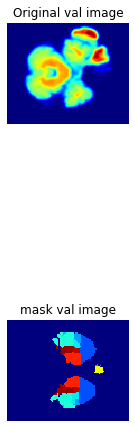

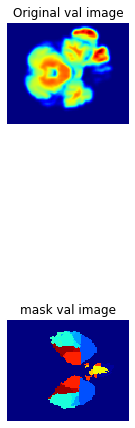

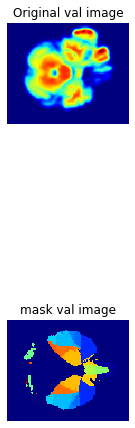

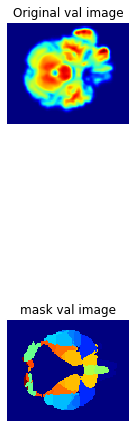

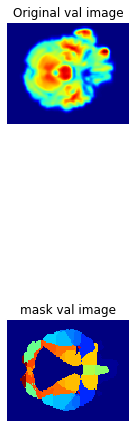

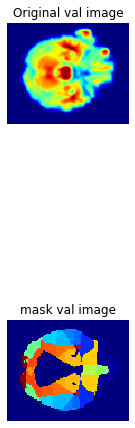

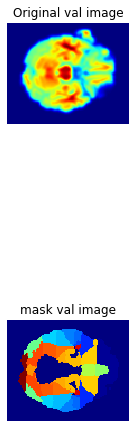

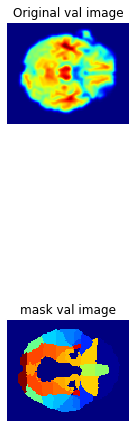

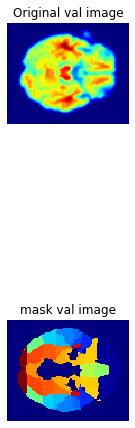

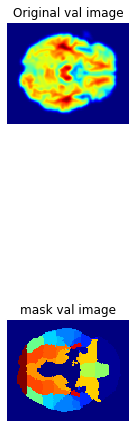

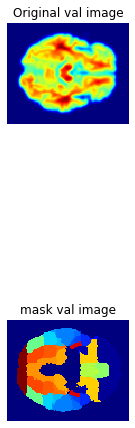

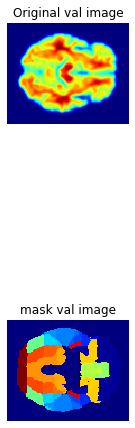

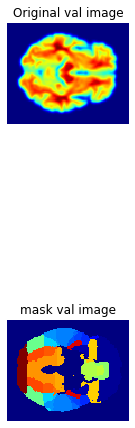

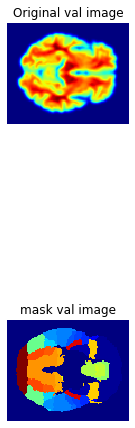

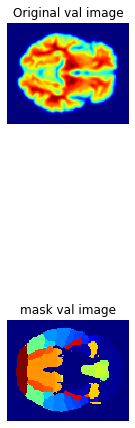

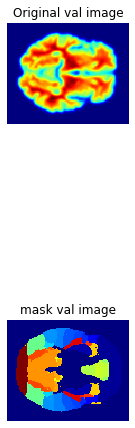

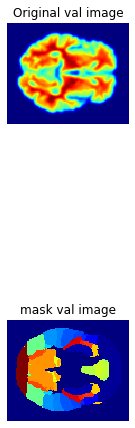

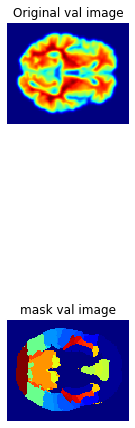

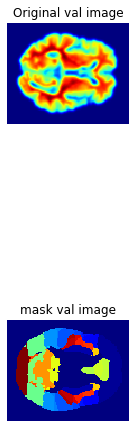

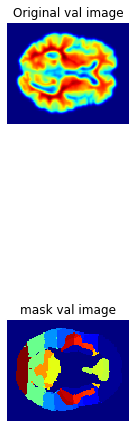

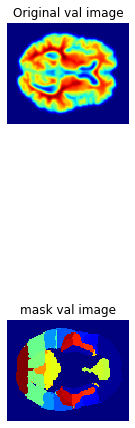

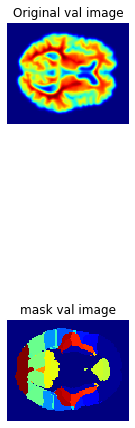

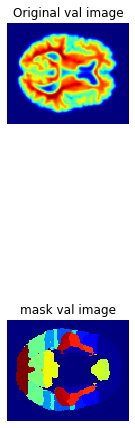

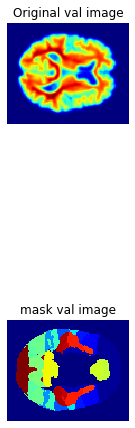

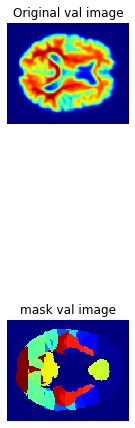

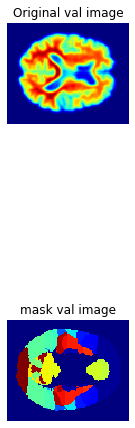

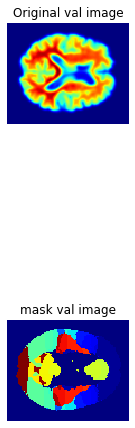

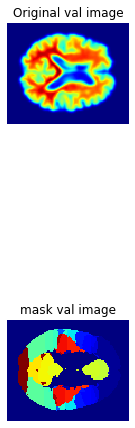

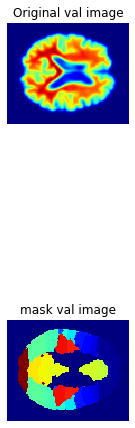

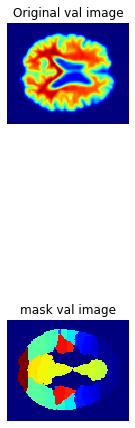

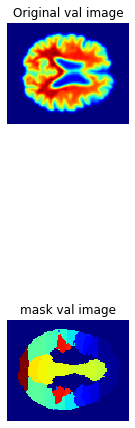

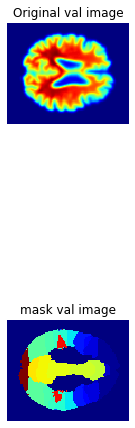

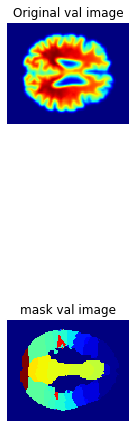

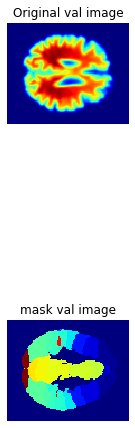

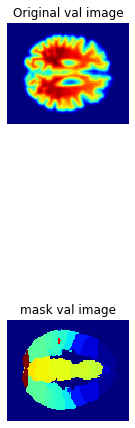

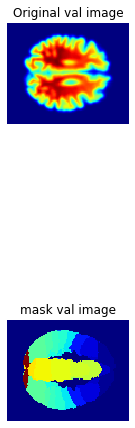

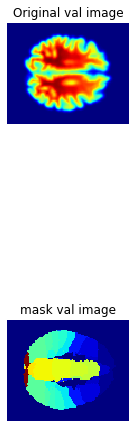

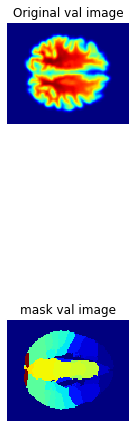

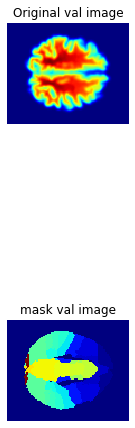

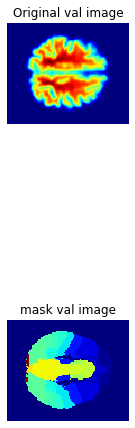

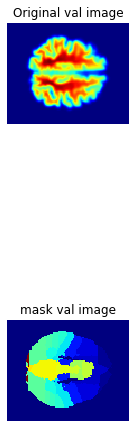

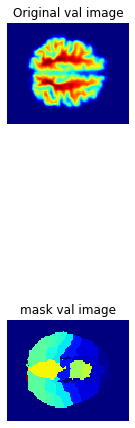

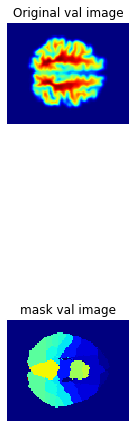

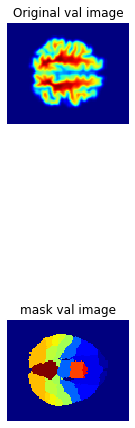

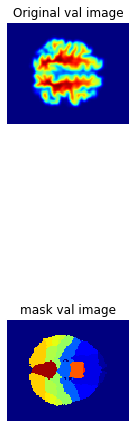

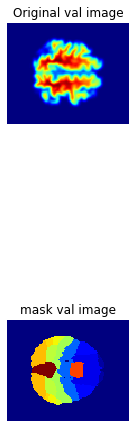

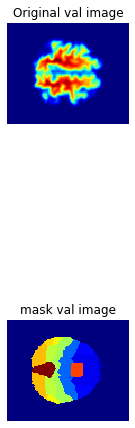

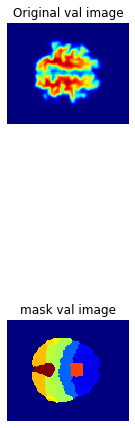

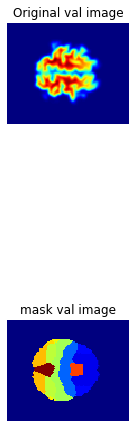

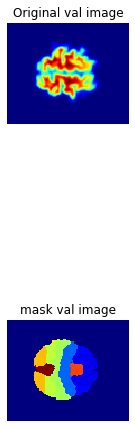

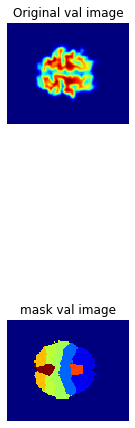

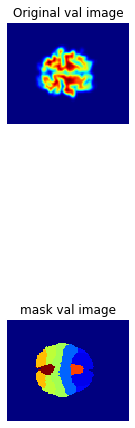

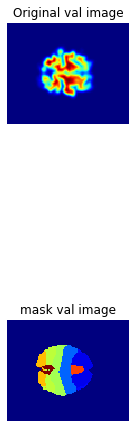

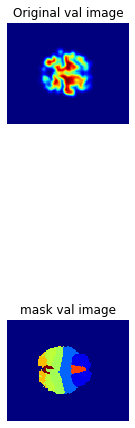

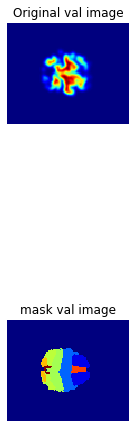

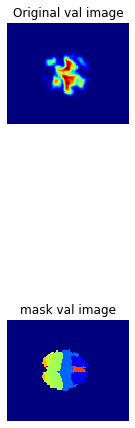

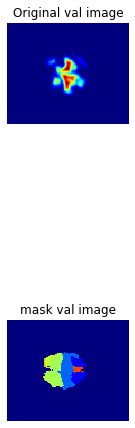

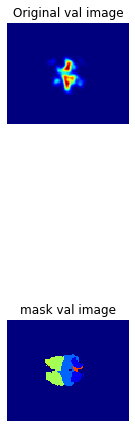

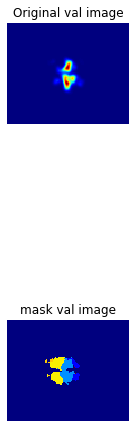

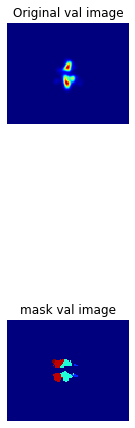

In [9]:
from nilearn import image
import subprocess


command = 'find ADNI/BET_Images | grep _BET.nii.gz' 

output = subprocess.run(command,
                        shell=True,
                        stdout=subprocess.PIPE,
                        universal_newlines=True)

paths = output.stdout.split()

# get atlas
labels, seg_region_img = get_seg_atlas(ATLAS_NAME) # atlas labels and 3D image mask

# Show THE ATLAS MASK
image_mask_data = seg_region_img.get_fdata()
plt.imshow(image_mask_data[:,:,40])

i = 1
for path in paths:
    if path == "ADNI/BET_Images/ADNI_002_S_0413_MR_MP-RAGE_REPEAT_br_raw_20060502143152716_1_S13894_I14438_BET.nii.gz":
        continue
    # smooth the 3D image at path (BET and FLIRT are already applied on the image at path)
    smoothed_image = image.smooth_img(path, fwhm=5)
    smoothed_image_data = smoothed_image.get_data()
    # divide the 3D images into 2D portuons and make sets
    if i < np.int(len(paths)*.7):
        seg_save_brains(path, image_mask_data, smoothed_image_data, 'train')
    elif np.int(len(paths) * .7) <= i < np.int(len(paths) * .9):
        seg_save_brains(path, image_mask_data, smoothed_image_data, 'val')
    else:
        seg_save_brains(path, image_mask_data, smoothed_image_data, 'test')
    i += 1

